In [ ]:
import numpy as np
from PIL import Image
import zipfile
import os
import math
import cv2
import copy

In [ ]:
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Lambda
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.layers import Layer
import keras

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

In [ ]:
from keras.models import load_model

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **Loading Dataset**

In [ ]:
# Path to the zip file in your Google Drive
zip_file_path = '/content/drive/My Drive/cancer.zip'

# Directory to extract the files to
extract_to_dir = '/content/'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_to_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)

print("Extraction complete.")


Extraction complete.


In [ ]:
train_b_path = '/content/train/Benign'
train_m_path = '/content/train/Malignant'

test_b_path = '/content/test/Benign'
test_m_path = '/content/test/Malignant'

In [ ]:
def load_image(file_path):
    img = cv2.imread(file_path)
    img = cv2.resize(img, (64, 64))
    return img.astype(np.float32)

def images_to_np(path, classs):
  total_images = len(os.listdir(path))
  # Initialize empty numpy array to store images
  images_array = np.empty((total_images, 64, 64, 3), dtype=np.uint8)

  # Iterate through each image file and load it into the array
  for i, filename in enumerate(os.listdir(path)):
      if filename.endswith(".jpg") or filename.endswith(".png"):  # Check if it's an image file
          image_path = os.path.join(path, filename)
          images_array[i] = load_image(image_path)

  print("Images loaded into NumPy array.")
  return images_array, np.array([classs for x in range(total_images)])

In [ ]:
b_x_train, b_y_train = images_to_np(train_b_path, 0)
m_x_train, m_y_train = images_to_np(train_m_path, 1)

b_x_test, b_y_test = images_to_np(test_b_path, 0)
m_x_test, m_y_test = images_to_np(test_m_path, 1)

Images loaded into NumPy array.
Images loaded into NumPy array.
Images loaded into NumPy array.
Images loaded into NumPy array.


In [ ]:
b_x_train.shape

(6289, 64, 64, 3)

In [ ]:
b_y_test.shape

(1000,)

# **Data Preprocessing**

In [ ]:
X_train = np.concatenate((b_x_train, m_x_train), axis=0)
y_train = np.concatenate((b_y_train, m_y_train), axis=0)

X_test = np.concatenate((b_x_test, m_x_test), axis=0)
y_test = np.concatenate((b_y_test, m_y_test), axis=0)

In [ ]:
# Scaling data
X_train = X_train / 255.0
X_test = X_test / 255.0

# One-hotencoding of target variables
y_cat_train = to_categorical(y_train, 2)
y_cat_test = to_categorical(y_test, 2)

# **Creating VGG16 Model Architecure**

**Defining the architecture**

In [ ]:
vgg16 = Sequential()

# Block 1
vgg16.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)))
vgg16.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
vgg16.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 2
vgg16.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
vgg16.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
vgg16.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 3
vgg16.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
vgg16.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
vgg16.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
vgg16.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 4
vgg16.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
vgg16.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
vgg16.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
vgg16.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 5
vgg16.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
vgg16.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
vgg16.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
vgg16.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Fully connected layers
vgg16.add(Flatten())
vgg16.add(Dense(4096, activation='relu'))
vgg16.add(Dense(4096, activation='relu'))
vgg16.add(Dense(2, activation='softmax'))  # Assuming 1000 classes for ImageNet

# Print model summary
vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                   

In [ ]:
vgg16.compile(
         optimizer=keras.optimizers.Adam(learning_rate=1e-4),
         loss='categorical_crossentropy',
         metrics=['accuracy'])

# **Data Augmentation**

In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
test_datagen = copy.deepcopy(train_datagen)

test_generator = test_datagen.flow(X_test, y_cat_test, batch_size=32)
train_generator = train_datagen.flow(X_train, y_cat_train, batch_size=32)

In [ ]:
train_generator.n

11879

# **Model training**

In [ ]:
# Define callbacks
checkpoint = ModelCheckpoint('vgg16_best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = vgg16.fit(train_generator,
                    epochs=20,
                    steps_per_epoch=300,
                    validation_data=(X_test, y_cat_test),
                    shuffle=True,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/20
300/300 [==============================] - ETA: 0s - loss: 0.2620 - accuracy: 0.8857
Epoch 1: val_loss improved from inf to 0.25240, saving model to vgg16_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


300/300 [==============================] - 23s 77ms/step - loss: 0.2620 - accuracy: 0.8857 - val_loss: 0.2524 - val_accuracy: 0.9075
Epoch 2/20
300/300 [==============================] - ETA: 0s - loss: 0.2568 - accuracy: 0.8912
Epoch 2: val_loss did not improve from 0.25240
300/300 [==============================] - 30s 101ms/step - loss: 0.2568 - accuracy: 0.8912 - val_loss: 0.3386 - val_accuracy: 0.8400
Epoch 3/20
300/300 [==============================] - ETA: 0s - loss: 0.2618 - accuracy: 0.8867
Epoch 3: val_loss did not improve from 0.25240
300/300 [==============================] - 22s 72ms/step - loss: 0.2618 - accuracy: 0.8867 - val_loss: 0.3480 - val_accuracy: 0.8440
Epoch 4/20
300/300 [==============================] - ETA: 0s - loss: 0.2560 - accuracy: 0.8895
Epoch 4: val_loss did not improve from 0.25240
300/300 [==============================] - 31s 103ms/step - loss: 0.2560 - accuracy: 0.8895 - val_loss: 0.3030 - val_accuracy: 0.8695
Epoch 5/20
300/300 [=================

In [ ]:
vgg16.save('vgg16_model_.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
best_model = load_model('vgg16_best_model.h5')

# **Performance Evaluation**

In [ ]:
print(f"Training Accuracy: {history.history['accuracy'][-1]}")

Training Accuracy: 0.9094517230987549


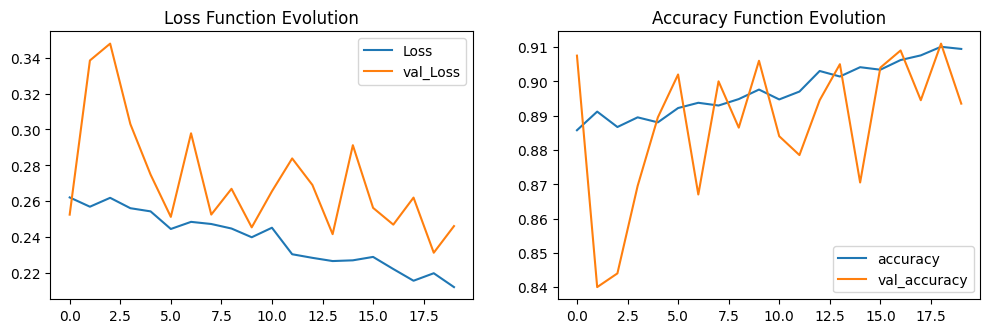

In [ ]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

In [ ]:
evaluation = vgg16.evaluate(X_test, y_cat_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

63/63 [==============================] - 1s 17ms/step - loss: 0.2460 - accuracy: 0.8935
Test Accuracy : 89.35%


63/63 [==============================] - 5s 75ms/step


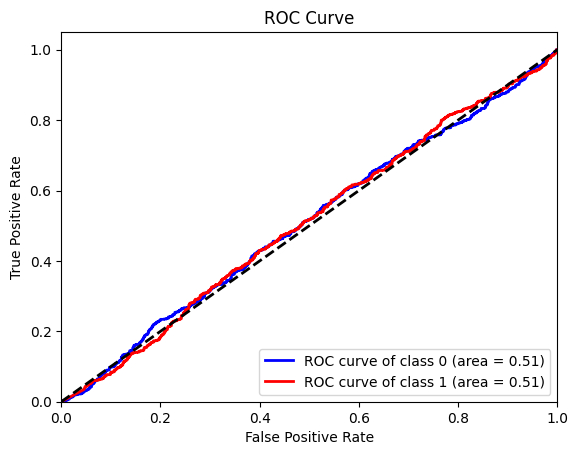

In [ ]:
# Step 1: Predict probabilities
y_pred_probs = vgg16.predict(test_generator)

# Convert one-hot encoded labels to binary labels
y_true = np.argmax(y_cat_test, axis=1)

# Step 2: Compute ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_cat_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve if needed
plt.figure()
lw = 2
colors = ['blue', 'red']  # for class 0 and class 1
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
y_pred = np.argmax(y_pred_probs, axis=1)

conf_mat = confusion_matrix(y_true, y_pred)
true_pos = np.diag(conf_mat)
false_pos = np.sum(conf_mat, axis=0) - true_pos
false_neg = np.sum(conf_mat, axis=1) - true_pos

intersection = true_pos
union = true_pos + false_pos + false_neg

iou = intersection / union

# Print IoU
print("IoU for each class:", iou)

IoU for each class: [0.3645288  0.32709633]


In [ ]:
labels = ['Benign', 'Malignant']

63/63 [==============================] - 1s 15ms/step


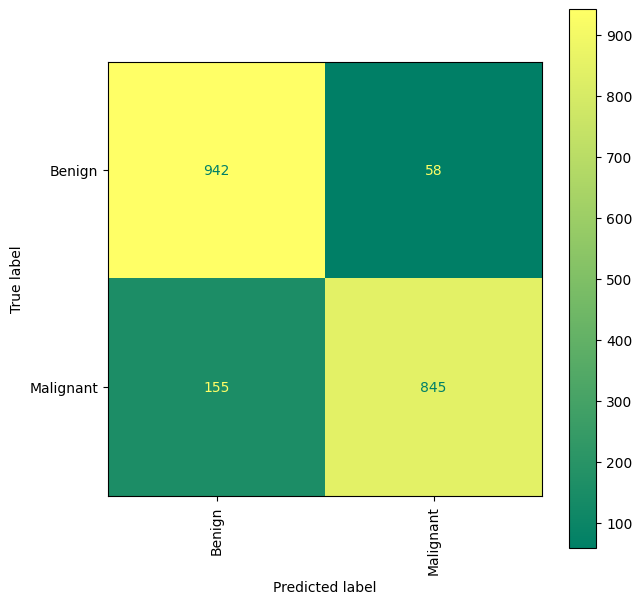

In [ ]:
y_pred = vgg16.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)

fig, ax = plt.subplots(figsize=(7, 7))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1000
           1       0.94      0.84      0.89      1000

    accuracy                           0.89      2000
   macro avg       0.90      0.89      0.89      2000
weighted avg       0.90      0.89      0.89      2000



**Testing the model**

 Image 999 has label 0
1/1 [==============================] - 0s 39ms/step
The model predict that image 999 label is 0(Benign)


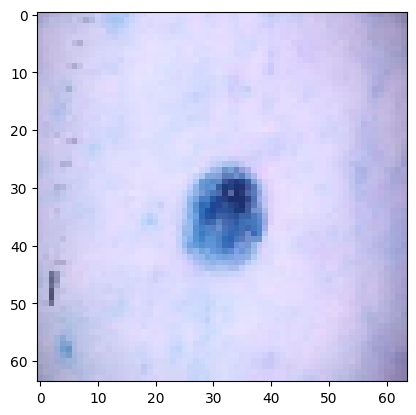

In [ ]:
img=999
my_image = X_test[img]
plt.imshow(my_image)

print(f" Image {img} has label {y_test[img]}")

pred_ = np.argmax(vgg16.predict(my_image.reshape(1, 64, 64, 3)))
print(f"The model predict that image {img} label is {pred_}({labels[pred_]})")

#below model prediction is correct

 Image 7 has label 0
1/1 [==============================] - 0s 30ms/step
The model predict that image 7 label is 1(Malignant)


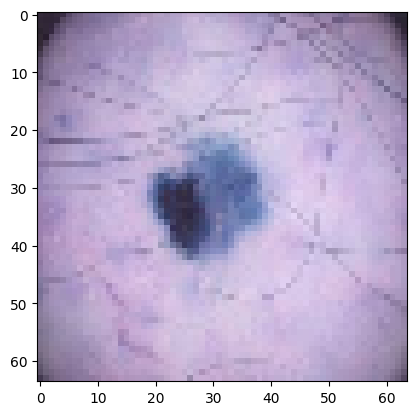

In [ ]:
img=7
my_image = X_test[img]
plt.imshow(my_image)

print(f" Image {img} has label {y_test[img]}")

pred_ = np.argmax(vgg16.predict(my_image.reshape(1, 64, 64, 3)))
print(f"The model predict that image {img} label is {pred_}({labels[pred_]})")

# below the model made a wrong prediction

 Image 400 has label 0
1/1 [==============================] - 0s 18ms/step
The model predict that image 400 label is 0(Benign)


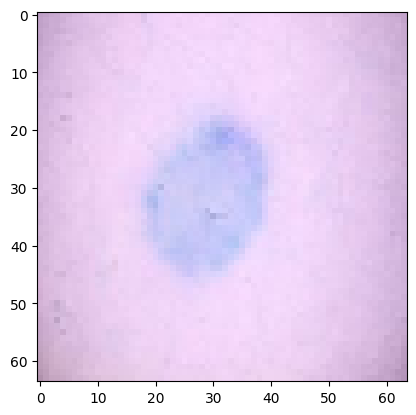

In [ ]:
img=400
my_image = X_test[img]
plt.imshow(my_image)

print(f" Image {img} has label {y_test[img]}")

# predicted correct
pred_ = np.argmax(vgg16.predict(my_image.reshape(1, 64, 64, 3)))
print(f"The model predict that image {img} label is {pred_}({labels[pred_]})")

#below model prediction is correct

 Image 830 has label 0
1/1 [==============================] - 0s 37ms/step
The model predict that image 830 label is 0(Benign)


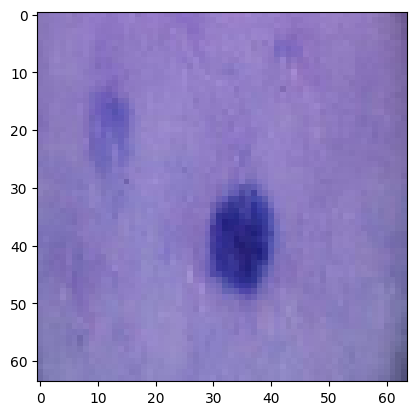

In [ ]:
img=830
my_image = X_test[img]
plt.imshow(my_image)


print(f" Image {img} has label {y_test[img]}")

# predicted correct
pred_ = np.argmax(vgg16.predict(my_image.reshape(1, 64, 64, 3)))
print(f"The model predict that image {img} label is {pred_}({labels[pred_]})")

#below model prediction is correct

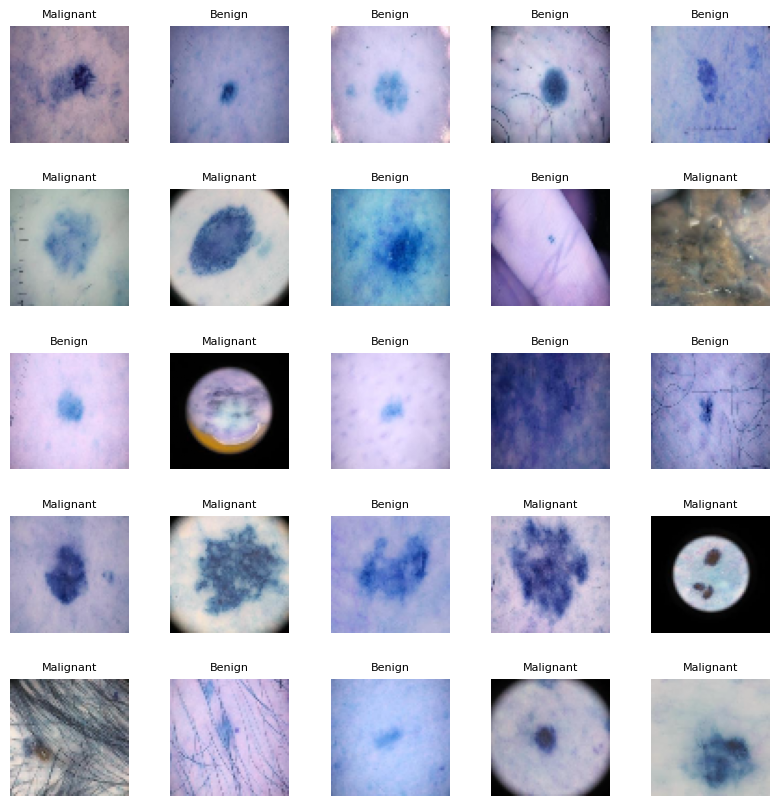

In [ ]:
W_grid = 5
L_grid = 5

fig, axes = plt.subplots(L_grid, W_grid, figsize = (10,10))

axes = axes.ravel()

n_test = len(X_test)

for i in np.arange(0, W_grid * L_grid):

    index = np.random.randint(0, n_test)
    axes[i].imshow(X_test[index,1:])
    label_index = int(y_pred[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})",
               color=color)
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(2))
    plt.yticks([])
    thisplot = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

63/63 [==============================] - 1s 15ms/step


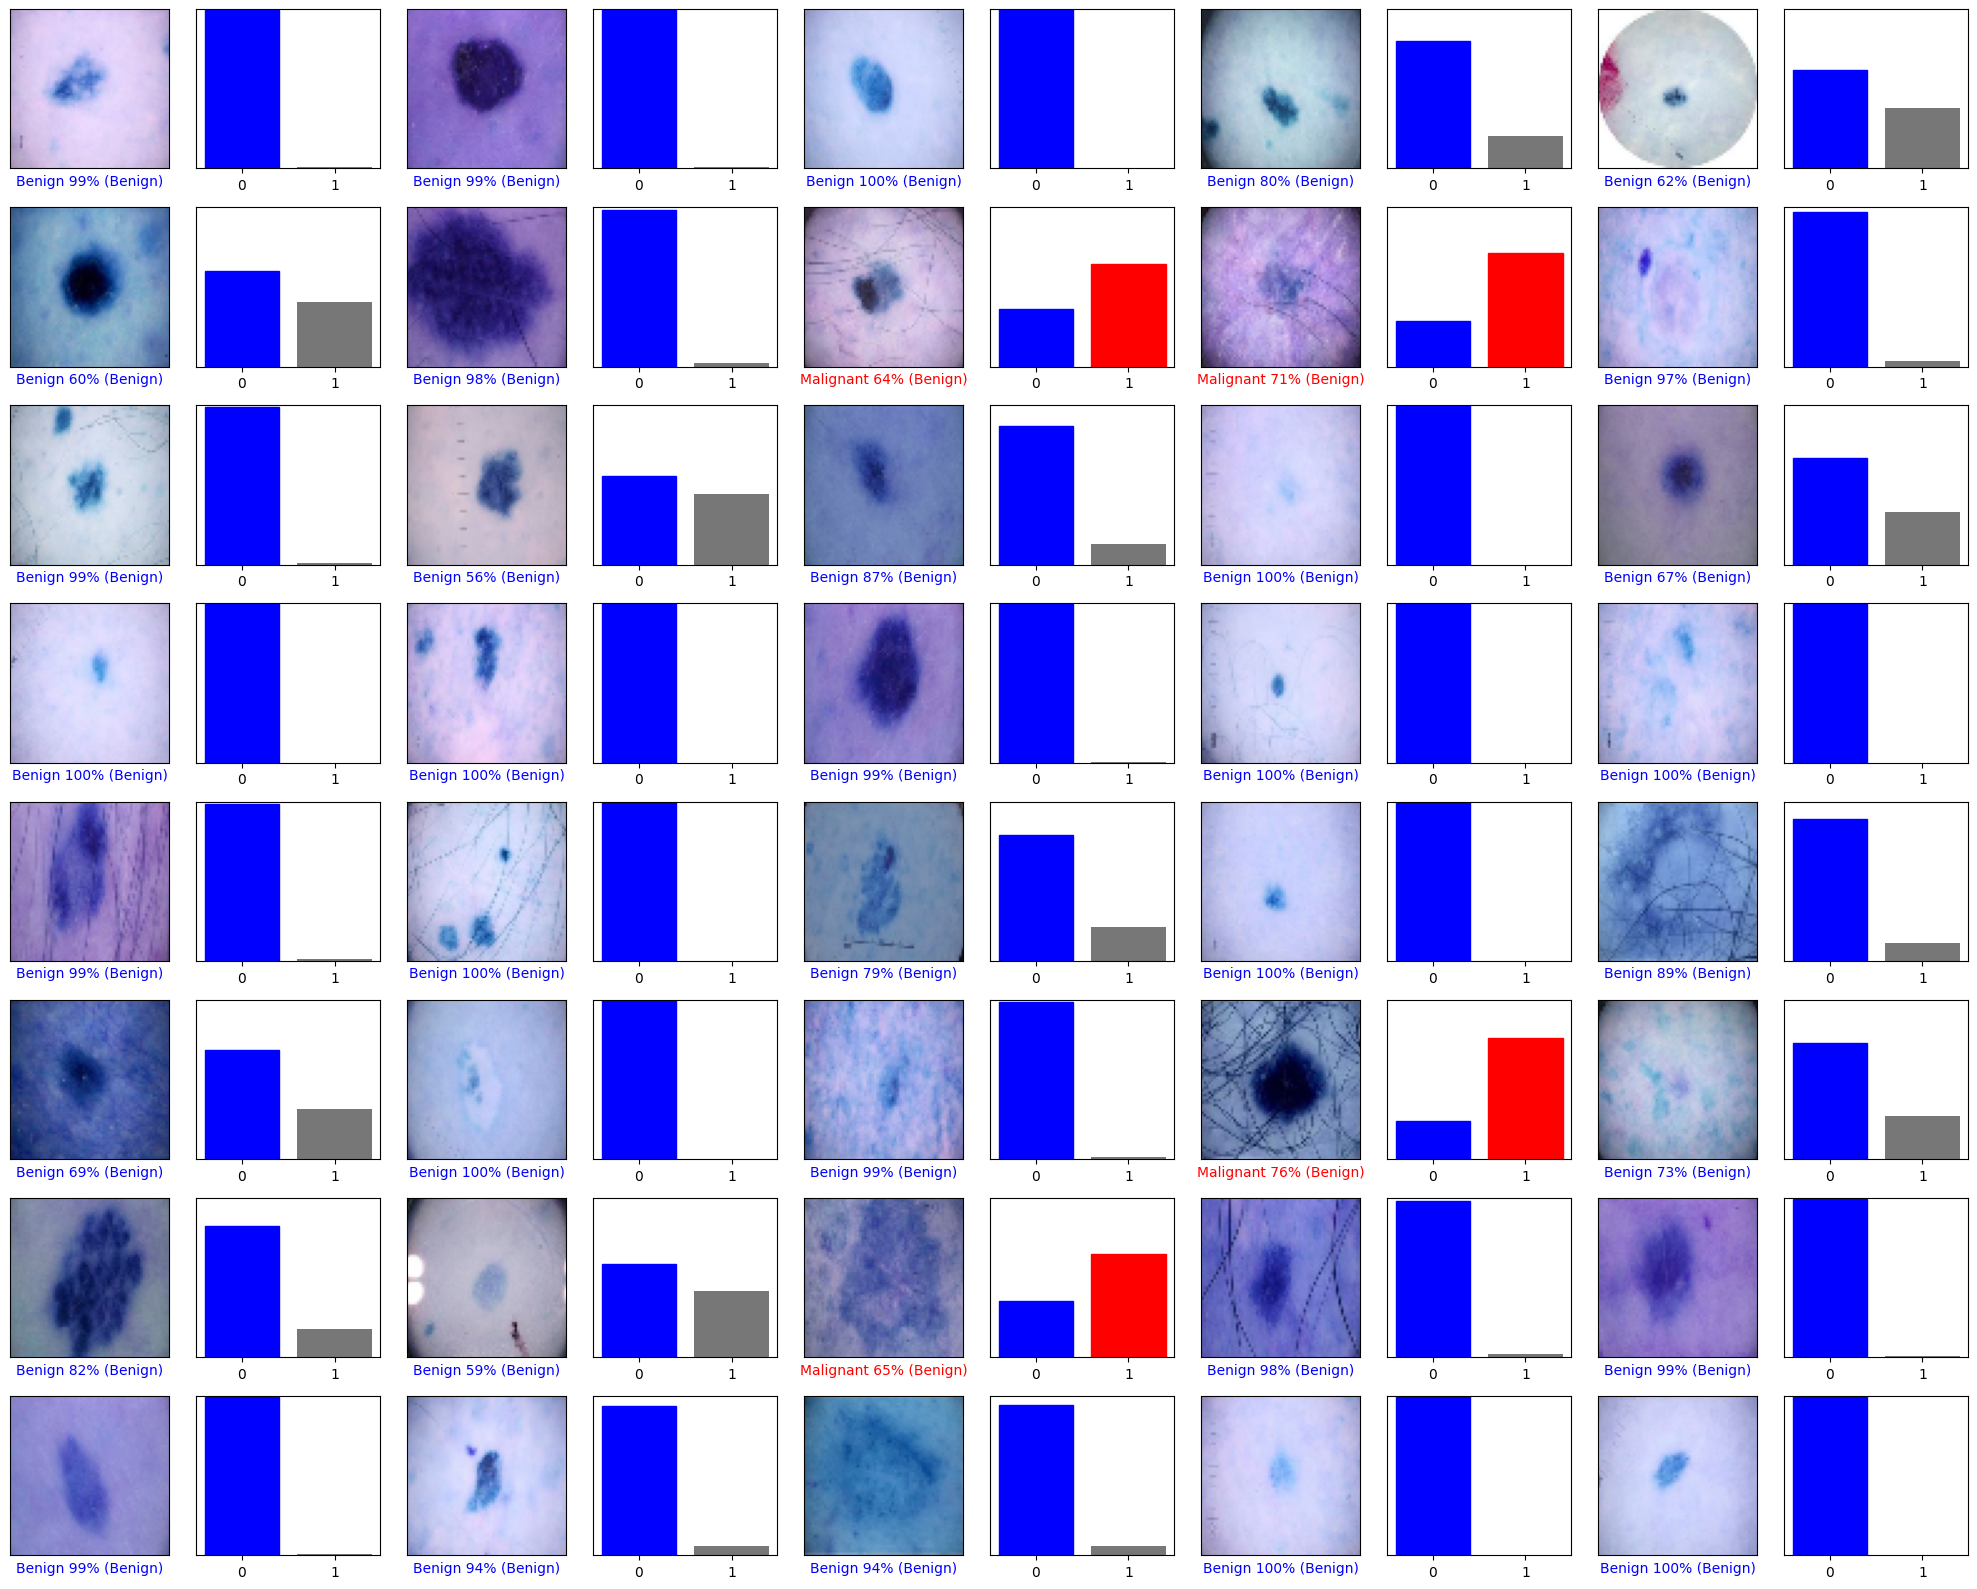

In [ ]:
predictions = vgg16.predict(X_test)

num_rows = 8
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()